# How to run time series forecasting at scale with the GluonTS toolkit on Amazon SageMaker

This notebook contains the notebook and training scripts for the blogpost **How to run time series forecasting at scale with GluonTS toolkit on Amazon SageMaker**

In this notebook we take the example of forecasting energy usage and show you how to train and tune multiple time series models across algorithms and hyper-parameter combinations using the GluonTS toolkit on Amazon SageMaker. We will first show you how to setup GlounTS on SageMaker using the MXNet estimator, then train multiple models using SageMaker Experiments, and finally use SageMaker Debugger to monitor suboptimal training and improve training efficiencies. We will walk you through the following steps:

1.	[Prepare the time series dataset](#section1)
2.	[Create the algorithm and hyper-parameters combinatorial matrix](#section2)
3.	[Setup the GluonTS training script](#section3)
4.  [Setup Amazon SageMaker Experiment and Trials](#section4)
5.	[Setup the MXNet Estimator](#section5)
6.	[Train and validate models](#section6)
7.	[Evaluate metrics and select a winning candidate](#section7)
8.	[Run time series forecasts](#section8)
9.  [Run experiment with SageMaker Debugger enabled to auto-terminate sub-optimal training jobs](#section9)


Before getting started we need to first install a few packages:

In [1]:
! pip install gluonts --upgrade
! pip install --upgrade sagemaker>=2.89.0
! pip install sagemaker-experiments
! pip install --upgrade smdebug-rulesconfig

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 58.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: gluonts
    Found existing installation: gluonts 0.8.1
    Uninstalling gluonts-0.8.1:
      Successfully uninstalled gluonts-0.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-forecasting 0.9.1 requires scikit-learn<0.25.0,>=0.24.0, but you have scikit-learn 1.0.2 which is incompatible.
profanity-filter 1.3.3 requires spacy<3.0,>=2.0, but you have spacy 3.1.3 which is incompatible.
multimodal-transformers 0.1.4a0 requires transformers==3.1, but you have transformers 

### 1. Prepare the time series dataset  <a name=section1></a>
For this exercise, we use the individual household electric power consumption dataset. (Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.) We aggregate the usage data hourly.

https://raw.githubusercontent.com/aws-samples/amazon-forecast-samples/master/notebooks/common/data/item-demand-time.csv


In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/aws-samples/amazon-forecast-samples/master/notebooks/common/data/item-demand-time.csv"
raw_df = pd.read_csv(url, header=None, names=["date", "usage", "client"])


Let's take a look on the data:

In [3]:
raw_df.head()

,date,usage,client
0,2014-01-01 01:00:00,38.349917,client_12
1,2014-01-01 02:00:00,33.582090,client_12
2,2014-01-01 03:00:00,34.411277,client_12
3,2014-01-01 04:00:00,39.800995,client_12
4,2014-01-01 05:00:00,41.044776,client_12


Define the S3 bucket and folder locations to store the test and training data. This should be within the same region as the Notebook Instance, training, and hosting. We will use the default SageMaker S3 bucket.

In [4]:
import boto3
import sagemaker 

s3_client = boto3.client('s3')
s3res = boto3.resource('s3')

sess = sagemaker.Session()
bucket = sess.default_bucket()

pref = 'electricity-forecast-experiment/gluonts'
s3_train_channel = "s3://" + bucket + "/" + pref + "/train.csv"
s3_test_channel = "s3://" + bucket + "/" + pref + "/test.csv"
print(s3_train_channel)
print(s3_test_channel)

s3://sagemaker-us-west-2-976939723775/electricity-forecast-experiment/gluonts/train.csv
s3://sagemaker-us-west-2-976939723775/electricity-forecast-experiment/gluonts/test.csv


Now let’s divide the raw data into train and test samples and save them in their respective s3 folder locations. 

In [5]:
df_train = raw_df.query('date <= "2014-31-10 11:00:00"').copy()
df_train.to_csv("train.csv")
s3_client.upload_file("train.csv", bucket, pref+"/train.csv")

In [6]:
df_test = raw_df.query('date >= "2014-1-11 12:00:00"').copy()
df_test.to_csv("test.csv")
s3_client.upload_file("test.csv", bucket, pref+"/test.csv")

### 2. Create the algorithm and hyper-parameters combinatorial matrix <a name=section2></a>

GluonTS comes with few pre-built models probabilistic forecasting models. Instead of simply predicting a single point estimate, probabilistic forecasting assigns a probability to every outcome. Once you select a model, you have the flexibility to configure the hyper-parameters to control the learning process. 

SageMaker supports bring your own model using Script mode. This allows you to leverage Amazon SageMaker prebuilt containers to train your models with the same kind of training script you would use outside of SageMaker. In this example, we use SageMaker's Apache MXNet containers to wrap 

In this example, we'll be training using four different models. 
- **DeepAR** is a supervised learning algorithm for forecasting scalar time series using recurrent neural networks (RNN). 
- **SFeedFwd** (Simple Feedforward) is a supervised learning algorithm where information moves in only one direction—forward—from the input nodes, through the hidden nodes (if any) and to the output nodes in the forward direction. 
- **LSTNet** (Long- and Short-term Time-series network) is a multivariate time series forecasting model that uses the combination of Convolution Neural Network (CNN) and the Recurrent Neural Network (RNN) to find short-term local dependency patterns among variables and them find long-term patterns for time series trends. 
- **Seq2Seq** (Sequence-to-sequence learning) is a method to train models to convert sequences from one domain to sequences in another domain. All these algorithms are already part of GluonTS, and we simply leverage it to quickly iterate and experiment over different models


A trainer defines how a network is going to be trained. Let’s define a trainer object using pandas dataframe that has the base list of algorithms, different epochs, learning rate, and hyper-parameter combinations that we want to define for our training runs. 
**Note:** If you want to add more alogrithm/hyper-parameter combinations, please add them to the dataframe defined as variable `d` 

In [7]:
import pandas as pd
d = {'epochs': [50,50], 'algo': ["DeepAR", "seq2seq"], 'num_batches_per_epoch': [25, 50], 'learning_rate':[1e-3,1e-3], 'hybridize':[True, True]}
df_hps = pd.DataFrame(data=d)
df_hps['prediction_length'] = [30, 60]
df_hps.head()

,epochs,algo,num_batches_per_epoch,learning_rate,hybridize,prediction_length
0,50,DeepAR,25,0.001,True,30
1,50,seq2seq,50,0.001,True,60


We will use the 'product' function to derive combinations of these parameters from the base set into separate rows in the dataframe. Each row corresponds to a training job configuration that we will subsequently pass to the MXNet Estimator to run the training job.

**Note** Please check your AWS account limits before you setup the product function below. The training process in the sections below will run one training job per row from this dataframe. Based on your account limit for the maximum number of concurrent training jobs, you may get an error that the limit has been exceeded. 

In [8]:
from itertools import product

prod = product(df_hps['epochs'].unique(), df_hps['algo'].unique(), df_hps['num_batches_per_epoch'].unique(), df_hps['learning_rate'].unique(), df_hps['hybridize'].unique(), df_hps['prediction_length'].unique())

df_hps_combo = pd.DataFrame([list(p) for p in prod],
                   columns=list(['epochs', 'algo', 'num_batches_per_epoch', 'learning_rate', 'hybridize', 'prediction_length']))

df_hps_combo['jobnumber'] = df_hps_combo.index

Let's take a look on the different combinations. 

In [9]:
df_hps_combo

,epochs,algo,num_batches_per_epoch,learning_rate,hybridize,prediction_length,jobnumber
0,50,DeepAR,25,0.001,True,30,0
1,50,DeepAR,25,0.001,True,60,1
2,50,DeepAR,50,0.001,True,30,2
3,50,DeepAR,50,0.001,True,60,3
4,50,seq2seq,25,0.001,True,30,4
5,50,seq2seq,25,0.001,True,60,5
6,50,seq2seq,50,0.001,True,30,6
7,50,seq2seq,50,0.001,True,60,7


### 3. Setup the GluonTS training script <a name=section3></a>

We will use a python entry script to import the necessary gluonts libraries, setup the gluonts estimators using the model packages for algorithms of interest, and pass in our algorithm and hyper-parameter preferences from the MXNet estimator we setup in the notebook. The script uses the train and test data files we uploaded to S3 to create the corresponding gluonts datasets for training and evaluation. After the completion of training, the script runs an evaluation to generate metrics, store them using the SageMaker Debugger Hook function, that we will later use to choose a winning model. For further analysis the metrics are also available via the SageMaker Trial Component analytics (please refer to Section 7 for more details). The model is then serialized for storage and future retrieval.  

In [11]:
#Let's take a look at the training script
!pygmentize blog_train_algos.py

import os
os.system('pip install pandas')
os.system('pip install gluonts')
import pandas as pd
import pathlib
import gluonts
import numpy as np
import argparse
import json
import boto3
from mxnet import gpu, cpu
from mxnet.context import num_gpus
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.lstnet import LSTNetEstimator
from gluonts.model.seq2seq import MQCNNEstimator
from gluonts.model.transformer import TransformerEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions, backtest_metrics
from gluonts.evaluation import Evaluator
from gluonts.model.predictor import Predictor
from gluonts.dataset.common import ListDataset
from gluonts.trainer import Trainer
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from smdebug.mxnet import Hook

s3 = boto3.client("s3")

def uploadDirectory(model_dir,prefix,bucket):
    

### 4. Setup a SageMaker Experiment  <a name=section4></a>

Before create the training job, we first create a SageMaker Experiment that will allow us to track the different training jobs. We use the `smexperiments` libraray to create the experiment:

In [12]:
from datetime import datetime
from smexperiments.experiment import Experiment

sagemaker_boto_client = boto3.client("sagemaker")

#name of experiment
timestep = datetime.now()
timestep = timestep.strftime("%d-%m-%Y-%H-%M-%S")
experiment_name = timestep + "-timeseries-models"

#create experiment
Experiment.create(
    experiment_name=experiment_name, 
    description="Timeseries models", 
    sagemaker_boto_client=sagemaker_boto_client)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fde9523f9a0>,experiment_name='13-05-2022-21-14-05-timeseries-models',description='Timeseries models',tags=None,experiment_arn='arn:aws:sagemaker:us-west-2:976939723775:experiment/13-05-2022-21-14-05-timeseries-models',response_metadata={'RequestId': '356f18e1-f6d1-43fd-aac3-5e61243f3a3e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '356f18e1-f6d1-43fd-aac3-5e61243f3a3e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '109', 'date': 'Fri, 13 May 2022 21:14:04 GMT'}, 'RetryAttempts': 0})

For each job we define a new Trial component within that experiment:

In [13]:
from smexperiments.trial import Trial

trial = Trial.create(
    experiment_name=experiment_name,
    sagemaker_boto_client=sagemaker_boto_client
)
print(trial)

Trial(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fde9523f9a0>,trial_name='Trial-2022-05-13-211407-gwov',experiment_name='13-05-2022-21-14-05-timeseries-models',tags=None,trial_arn='arn:aws:sagemaker:us-west-2:976939723775:experiment-trial/trial-2022-05-13-211407-gwov',response_metadata={'RequestId': 'c5ac6d3e-3be2-4294-82c6-73a9fbb8ff2b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c5ac6d3e-3be2-4294-82c6-73a9fbb8ff2b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '101', 'date': 'Fri, 13 May 2022 21:14:07 GMT'}, 'RetryAttempts': 0})


Next we define an experiment config which is a dictionary that we pass into the `fit()` method later on. This ensures that the training job that is going to be started is associate with that experiment and trial.

In [14]:
experiment_config = { "ExperimentName": experiment_name, 
                      "TrialName":  trial.trial_name,
                      "TrialComponentDisplayName": "Training"}

In [16]:
# role = sagemaker.get_execution_role()
role = 'arn:aws:iam::976939723775:role/service-role/AmazonSageMaker-ExecutionRole-20210317T133000'

### 5. Create the MXNet Estimator  <a name=section5></a>

MXNet training scripts could be run on Amazon SageMaker by creating an [MXNet estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/using_mxnet.html). The training job will start when the fit function on an MXNet estimator is called. We pass in a hyperparameter dictionary that takes the inputs from the algorithm and hyper-parameters combinatorial matrix.

In [17]:
import sagemaker
from sagemaker.mxnet import MXNet

mxnet_estimator = MXNet(entry_point='blog_train_algos.py',
                        role=role,
                        instance_type='ml.m5.2xlarge',
                        instance_count=1,
                        framework_version='1.7.0', 
                        py_version='py3',
                        hyperparameters={'bucket': bucket,
                            'seq': trial.trial_name,
                            'algo': "DeepAR",             
                            'freq': "D", 
                            'prediction_length': 30, 
                            'epochs': 10,
                            'learning_rate': 1e-3,
                            'hybridize': False,
                            'num_batches_per_epoch': 10,
                         })

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset. Train by invoking the train method of the estimator. We pass the location of train and test-data as well as the experiment configuration.

The training algorithm returns a fitted model (or a Predictor in GluonTS parlance) that can be used to construct forecasts.

In [19]:
mxnet_estimator.fit({"train": s3_train_channel, "test": s3_test_channel}, 
                    experiment_config=experiment_config,
                    wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: mxnet-training-2022-05-13-21-27-09-978


2022-05-13 21:27:10 Starting - Starting the training job...
2022-05-13 21:27:36 Starting - Preparing the instances for trainingProfilerReport-1652477230: InProgress
......
2022-05-13 21:28:36 Downloading - Downloading input data...
2022-05-13 21:28:57 Training - Downloading the training image...
2022-05-13 21:29:38 Training - Training image download completed. Training in progress..2022-05-13 21:29:39,959 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-05-13 21:29:39,961 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-13 21:29:39,973 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"algo":"DeepAR","bucket":"sagemaker-us-west-2-976939723775","epochs":10,"freq":"D","hybridize":false,"learning_rate":0.001,"num_batches_per_epoch":10,"prediction_length":30,"seq":"Trial-2022-05-13-211407-gwov"}', 'SM_USER_

### 6. Setup experiment with Debugger enabled to auto-terminate sub-optimal training jobs  <a name=section6></a>

We ran a parameter sweep and created lots of different configurations. Doing so may produce parameter combinations that lead to sub-optimal models. We can use SageMaker Debugger to tune our experiment at training time. Debugger automatically captures data from the model training and provides builtin rules that check for conditions such as overfitting, vanishing gradients etc. We can then specify actions to auto-terminate training jobs ahead of time that would otherwise produce low-quality models.

Some of the models in our experiment use Recurrent Neural Networks that can suffer from the vanishing gradient problem. So we select Debugger's tensor variance thats allows to specify and upper and lower bound on the gradient values. We also specify the action `StopTraining` that will stop a training job once the rule triggers.


In [20]:
from sagemaker.debugger import Rule, CollectionConfig, rule_configs

actions = rule_configs.ActionList(
    rule_configs.StopTraining(), 
)

rule = Rule.sagemaker(base_config=rule_configs.tensor_variance(),
                      rule_parameters={"min_threshold": '0.00001',
                                       "max_threshold": '100000.0',
                                       "collection_names": 'custom_collection'},
                      actions=actions )

Per default Debugger collects data with an interval of 500 steps. In our case, training dataset is small and our models only train for few minutes, so we can decrease the save interval. Here we create a custom collection, where we collect gradients at an interval of 5.

In [21]:
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

debugger_hook_config = DebuggerHookConfig(
      collection_configs=[ 
          CollectionConfig(
                name="custom_collection",
                parameters={ "include_regex": "(.*gradient)(?!.*featureembedder)(.*weight)",
                             "start_step": "10",
                             "save_interval": "5"})])

Next we create a new experiment:

In [22]:
from datetime import datetime
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial

sagemaker_boto_client = boto3.client("sagemaker")

#name of experiment
timestep = datetime.now()
timestep = timestep.strftime("%d-%m-%Y-%H-%M-%S")
experiment_name = timestep + "-timeseries-models"

#create experiment
Experiment.create(
    experiment_name=experiment_name, 
    description="Timeseries models", 
    sagemaker_boto_client=sagemaker_boto_client)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fde94b6ee20>,experiment_name='13-05-2022-21-31-04-timeseries-models',description='Timeseries models',tags=None,experiment_arn='arn:aws:sagemaker:us-west-2:976939723775:experiment/13-05-2022-21-31-04-timeseries-models',response_metadata={'RequestId': '7ab80f07-fb83-429c-8c77-8a0cc1696eb7', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7ab80f07-fb83-429c-8c77-8a0cc1696eb7', 'content-type': 'application/x-amz-json-1.1', 'content-length': '109', 'date': 'Fri, 13 May 2022 21:31:03 GMT'}, 'RetryAttempts': 0})

### 7. Train and validate models <a name=section7></a>

In section 5 we trained one model. Now we iterate over all possible combinations of hyperparameters and algorithms with the SageMaker Debugger rules enabled to detect problems such as vanishing gradients and terminate these training jobs.


In [24]:
import sagemaker
from sagemaker.mxnet import MXNet

for idx, row in df_hps_combo.iterrows():

    trial = Trial.create(
        experiment_name=experiment_name,
        sagemaker_boto_client=sagemaker_boto_client
    )

    experiment_config = { "ExperimentName": experiment_name, 
                      "TrialName":  trial.trial_name,
                      "TrialComponentDisplayName": "Training"}
    
    mxnet_estimator = MXNet(entry_point='blog_train_algos.py',
                        role=role,
                        instance_type='ml.m5.large',
                        instance_count=1,
                        framework_version='1.7.0', py_version='py3',
                        debugger_hook_config=debugger_hook_config,
                        rules=[rule],
                        hyperparameters={'bucket': bucket, 'seq': trial.trial_name,
                            'algo': row['algo'],             
                            'freq': "D", 
                            'prediction_length': row['prediction_length'], 
                            'epochs': row['epochs'],
                            'learning_rate': row['learning_rate'],
                            'hybridize': row['hybridize'],
                            'num_batches_per_epoch': row['num_batches_per_epoch']
                         })

    mxnet_estimator.fit({"train": s3_train_channel, "test": s3_test_channel}, 
                        experiment_config=experiment_config,
                        wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: mxnet-training-2022-05-13-21-31-19-989
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: mxnet-training-2022-05-13-21-31-20-808
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: mxnet-training-2022-05-13-21-31-23-718
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm vers

Once the experiment is finished we can determine how many seconds it ran. First we define a helper function to compute the billabale seconds and how many training jobs were auto-terminated.

In [25]:
import time

def compute_job_statistics(df):
    total_cost  = 0
    stopped = 0
    for name in df['sagemaker_job_name']:
        while  sagemaker_boto_client.describe_training_job(TrainingJobName=name[1:-1])['TrainingJobStatus'] == 'InProgress':
            print('Experiment is still in progress')
            time.sleep(30)
            continue
        total_cost += sagemaker_boto_client.describe_training_job(TrainingJobName=name[1:-1])['BillableTimeInSeconds']
        if sagemaker_boto_client.describe_training_job(TrainingJobName=name[1:-1])['TrainingJobStatus'] == "Stopped":
            stopped += 1
    return stopped, total_cost

In [37]:
from sagemaker.analytics import ExperimentAnalytics
trial_component_analytics = ExperimentAnalytics(experiment_name=experiment_name)

stopped, total_cost = compute_job_statistics(trial_component_analytics.dataframe())
print("Billable seconds for overall experiment with Debugger:", total_cost, "seconds. Number of training jobs auto-terminated:", stopped)

Billable seconds for overall experiment with Debugger: 5817 seconds. Number of training jobs auto-terminated: 2


This setup is especially useful if you run a parameter sweep with training jobs that train for hours. In our case each job only trained for less than 10 minutes. Until the Debugger data is uploaded, fetched and downloaded into the processing job, a few minutes may pass, so the potential cost reduction will be less for smaller training jobs.

### 8. Evaluate metrics and select a winning candidate <a name=section8></a>

Amazon SageMaker Studio provides an experiments browser that you can use to view lists of experiments, trials, and trial components. You can choose one of these entities to view detailed information about the entity or choose multiple entities for comparison. For more details please refer to [the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments-view-compare.html#experiments-view). Once the training jobs are running we can use the experiment view in Studio (see screenshot below) or the `ExperimentAnalytics` module to track the status of our training jobs and their metrics. 
![](screenshot.png)


In the training script we used SageMaker Debugger's function `save_scalar` to store metrics such as MAPE, MSE, RMSE in the experiment. We can access the recorded metrics via the ExperimentAnalytics function and convert it to a Pandas dataframe.


In [39]:
from sagemaker.analytics import ExperimentAnalytics

trial_component_analytics = ExperimentAnalytics(experiment_name=experiment_name)
tc_df = trial_component_analytics.dataframe()
tc_df

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,algo,bucket,epochs,...,scalar/MAPE_GLOBAL - Avg,scalar/MAPE_GLOBAL - StdDev,scalar/MAPE_GLOBAL - Last,scalar/MAPE_GLOBAL - Count,scalar/MSE_GLOBAL - Min,scalar/MSE_GLOBAL - Max,scalar/MSE_GLOBAL - Avg,scalar/MSE_GLOBAL - StdDev,scalar/MSE_GLOBAL - Last,scalar/MSE_GLOBAL - Count
0,mxnet-training-2022-05-13-21-31-28-742-aws-tra...,Training,arn:aws:sagemaker:us-west-2:976939723775:train...,763104351884.dkr.ecr.us-west-2.amazonaws.com/m...,1.0,ml.m5.large,30.0,"""seq2seq""","""sagemaker-us-west-2-976939723775""",50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mxnet-training-2022-05-13-21-31-32-914-aws-tra...,Training,arn:aws:sagemaker:us-west-2:976939723775:train...,763104351884.dkr.ecr.us-west-2.amazonaws.com/m...,1.0,ml.m5.large,30.0,"""seq2seq""","""sagemaker-us-west-2-976939723775""",50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mxnet-training-2022-05-13-21-31-31-973-aws-tra...,Training,arn:aws:sagemaker:us-west-2:976939723775:train...,763104351884.dkr.ecr.us-west-2.amazonaws.com/m...,1.0,ml.m5.large,30.0,"""seq2seq""","""sagemaker-us-west-2-976939723775""",50.0,...,0.163852,0.0,0.163852,1.0,126.476685,126.476685,126.476685,0.0,126.476685,1.0
3,mxnet-training-2022-05-13-21-31-26-391-aws-tra...,Training,arn:aws:sagemaker:us-west-2:976939723775:train...,763104351884.dkr.ecr.us-west-2.amazonaws.com/m...,1.0,ml.m5.large,30.0,"""DeepAR""","""sagemaker-us-west-2-976939723775""",50.0,...,0.289838,0.0,0.289838,1.0,359.545866,359.545866,359.545866,0.0,359.545866,1.0
4,mxnet-training-2022-05-13-21-31-23-718-aws-tra...,Training,arn:aws:sagemaker:us-west-2:976939723775:train...,763104351884.dkr.ecr.us-west-2.amazonaws.com/m...,1.0,ml.m5.large,30.0,"""DeepAR""","""sagemaker-us-west-2-976939723775""",50.0,...,0.206002,0.0,0.206002,1.0,194.248258,194.248258,194.248258,0.0,194.248258,1.0
5,mxnet-training-2022-05-13-21-31-27-601-aws-tra...,Training,arn:aws:sagemaker:us-west-2:976939723775:train...,763104351884.dkr.ecr.us-west-2.amazonaws.com/m...,1.0,ml.m5.large,30.0,"""seq2seq""","""sagemaker-us-west-2-976939723775""",50.0,...,0.143886,0.0,0.143886,1.0,96.659253,96.659253,96.659253,0.0,96.659253,1.0
6,mxnet-training-2022-05-13-21-31-19-989-aws-tra...,Training,arn:aws:sagemaker:us-west-2:976939723775:train...,763104351884.dkr.ecr.us-west-2.amazonaws.com/m...,1.0,ml.m5.large,30.0,"""DeepAR""","""sagemaker-us-west-2-976939723775""",50.0,...,0.217358,0.0,0.217358,1.0,207.943571,207.943571,207.943571,0.0,207.943571,1.0
7,mxnet-training-2022-05-13-21-31-20-808-aws-tra...,Training,arn:aws:sagemaker:us-west-2:976939723775:train...,763104351884.dkr.ecr.us-west-2.amazonaws.com/m...,1.0,ml.m5.large,30.0,"""DeepAR""","""sagemaker-us-west-2-976939723775""",50.0,...,0.185396,0.0,0.185396,1.0,246.294857,246.294857,246.294857,0.0,246.294857,1.0


Let's take a look on the metrics and hyperparameter combinations:

In [40]:
new_df = tc_df[['Trials','epochs', 'learning_rate', 'hybridize', 'num_batches_per_epoch','prediction_length','scalar/MASE_GLOBAL - Min', 'scalar/MSE_GLOBAL - Min', 'scalar/RMSE_GLOBAL - Min', 'scalar/MAPE_GLOBAL - Min']]
new_df   

,Trials,epochs,learning_rate,hybridize,num_batches_per_epoch,prediction_length,scalar/MASE_GLOBAL - Min,scalar/MSE_GLOBAL - Min,scalar/RMSE_GLOBAL - Min,scalar/MAPE_GLOBAL - Min
0,[Trial-2022-05-13-213128-yhmi],50.0,0.001,true,25.0,60.0,NaN,NaN,NaN,NaN
1,[Trial-2022-05-13-213132-okpr],50.0,0.001,true,50.0,60.0,NaN,NaN,NaN,NaN
2,[Trial-2022-05-13-213131-qwcb],50.0,0.001,true,50.0,30.0,1.260422,126.476685,11.246185,0.163852
3,[Trial-2022-05-13-213126-fvcx],50.0,0.001,true,50.0,60.0,2.351084,359.545866,18.961695,0.289838
4,[Trial-2022-05-13-213123-afhj],50.0,0.001,true,50.0,30.0,1.517736,194.248258,13.937297,0.206002
5,[Trial-2022-05-13-213127-rgbx],50.0,0.001,true,25.0,30.0,1.114788,96.659253,9.831544,0.143886
6,[Trial-2022-05-13-213119-qmft],50.0,0.001,true,25.0,30.0,1.598659,207.943571,14.420249,0.217358
7,[Trial-2022-05-13-213120-lenw],50.0,0.001,true,25.0,60.0,1.571311,246.294857,15.693784,0.185396


The smallest MAPE achieved is:

In [41]:
mape_min = new_df['scalar/MAPE_GLOBAL - Min'].min()
mape_min

0.1438860257466634

Let's select the winner model:

In [44]:
df_winner = new_df[new_df['scalar/MAPE_GLOBAL - Min'] == mape_min]
if len(df_winner)!=1: #the df_winner should only content 1 model    
    df_winner=df_winner.head(1)

In [46]:
df_winner

,Trials,epochs,learning_rate,hybridize,num_batches_per_epoch,prediction_length,scalar/MASE_GLOBAL - Min,scalar/MSE_GLOBAL - Min,scalar/RMSE_GLOBAL - Min,scalar/MAPE_GLOBAL - Min
5,[Trial-2022-05-13-213127-rgbx],50.0,0.001,true,25.0,30.0,1.114788,96.659253,9.831544,0.143886


Next we download the winner model:

In [47]:
#download the champion from S3 and store it in the winner folder
import os
s3 = boto3.client("s3")
windir = "gluonts/blog-models/"+str(df_winner['Trials'].item()).replace("['","").replace("']","")+"/"

def downloadDirectoryFroms3(bucket, windir):
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucket) 
    for obj in bucket.objects.filter(Prefix = windir):
        print(obj.key)
        if not os.path.exists(os.path.dirname(windir)):
            os.makedirs(os.path.dirname(windir))
        bucket.download_file(obj.key, obj.key) # save to same path


downloadDirectoryFroms3(bucket, windir) 

gluonts/blog-models/Trial-2022-05-13-213127-rgbx/input_transform.json
gluonts/blog-models/Trial-2022-05-13-213127-rgbx/parameters.json
gluonts/blog-models/Trial-2022-05-13-213127-rgbx/prediction_net-0000.params
gluonts/blog-models/Trial-2022-05-13-213127-rgbx/prediction_net-network.json
gluonts/blog-models/Trial-2022-05-13-213127-rgbx/type.txt
gluonts/blog-models/Trial-2022-05-13-213127-rgbx/version.json


### 9. Run time series forecasts   <a name=section9></a>
After we have downloaded the model, we can run prediction on it. Therefore we use the predictor API from GluonTS, that takes the path to the model files:

In [48]:
# restore the predictor
import pathlib
from gluonts.model.predictor import Predictor

path = pathlib.Path(windir)   
winning_predictor = Predictor.deserialize(path)

/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
INFO:gluonts.mx.context:Using CPU


Next we run predictions on the test dataset and visualize them:

/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/feature.py:343:

2014-11-30 00:00:00


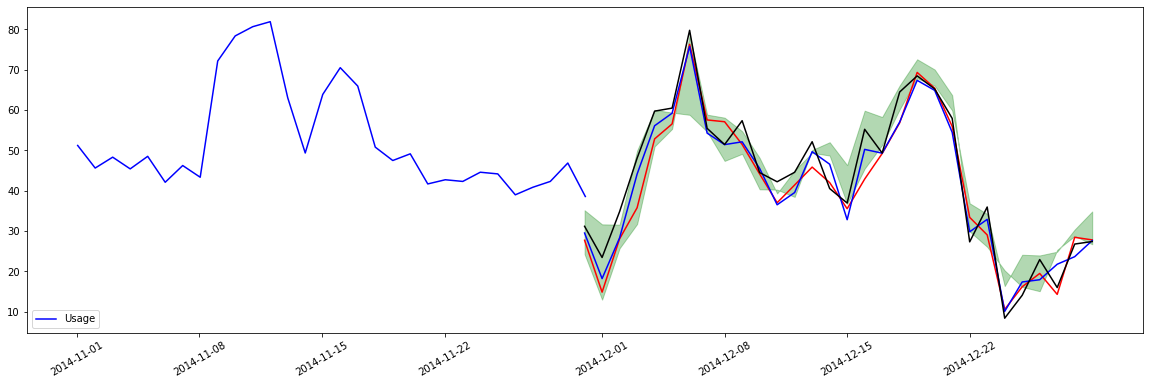

In [49]:
import matplotlib.pyplot as plt
from gluonts.dataset.common import ListDataset
plt.rcParams['figure.figsize'] = (20.0, 6.0)

# run forecast
startdate = '2014-11-01 01:00:00'
test_pred = ListDataset(
    [{"start": startdate, "target": raw_df.query('date >= "2014-11-01 01:00:00" and client == "client_12"').copy()['usage'], "item_id": 'client_12'}],
    freq = "1H"
)

pred = winning_predictor.predict(test_pred)
for test_entry, forecast in zip(test_pred, pred):
    print(forecast.start_date)
    plt.plot(pd.date_range(start=startdate, periods=30), pd.DataFrame.from_dict(test_entry['target'])[0][:30],color='b')
    plt.plot(pd.date_range(start=forecast.start_date, periods=df_winner['prediction_length'].item()), forecast.quantile(.3), color='r') #samples contain all 100 quantiles
    plt.plot(pd.date_range(start=forecast.start_date, periods=df_winner['prediction_length'].item()), forecast.quantile(.5), color='b') #samples contain all 100 quantiles
    plt.plot(pd.date_range(start=forecast.start_date, periods=df_winner['prediction_length'].item()), forecast.quantile(.7), color='k') #samples contain all 100 quantiles
    x=pd.date_range(start=forecast.start_date, periods=df_winner['prediction_length'].item()) #samples contain all 100 quantiles
    y=forecast.quantile(.1) 
    z=forecast.quantile(.9)
    plt.fill_between(x,y,z,color='g', alpha=0.3)
plt.xticks(rotation=30)
plt.legend(['Usage'], loc = 'lower left')
plt.show()


## Conclusion



With Amazon SageMaker we saw how easy it is for every developer and data scientist to setup time series forecasting at scale using the MXNet Estimator with the GluonTS toolkit. Amazon SageMaker removes the undifferentiated heavy lifting from every step of our ML process, automates infrastructure management, enables us to improve the training efficiency with SageMaker Debugger, and accelerates adoption of ML workflows from months to days. Please try out the notebook (https://a2i-experiments.notebook.us-east-1.sagemaker.aws/notebooks/gluonTS/rauscn/blog-gluonts-toolkit-on-sagemaker-PR.ipynb) from our post and let us know your comments and feedback.